In [3]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv, lstsq

from scipy.optimize import minimize_scalar

from poly_basis import *
from spherepts import *
from rbf import *

from laplacebeltrami import *
from sphere_gaussians import *

from math import factorial as fac

In [ ]:
def schur_solve(A, P, f, g, rcond=1e-15):
    lam = la.pinv(P.T @ la.solve(A, P), rcond=rcond) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam

In [7]:
def grad_poly(nodes, projectors, deg):
    n = len(nodes)
    x = nodes[:,0]
    y = nodes[:,1]
    z = nodes[:,2]

    poly_scale_x = np.max(np.abs(x))
    poly_scale_y = np.max(np.abs(y))
    poly_scale_z = np.max(np.abs(z))
    
    x = x / poly_scale_x
    y = y / poly_scale_y
    z = z / poly_scale_z

    cols = fac(deg+3)//(fac(deg)*fac(3))
    P = np.zeros((n, cols))
    rhs_dx = np.zeros((cols, n))
    rhs_dy = np.zeros((cols, n))
    rhs_dz = np.zeros((cols, n))
    rhs_x = np.zeros((cols, n))
    rhs_y = np.zeros((cols, n))
    rhs_z = np.zeros((cols, n))
    i = 0
    for d in range(deg+1):
        #x^a y^b z^c with a+b+c = d
        for a in range(d,-1, -1):
            for b in range(d-a, -1, -1):
                c = d-a-b
                P[:,i] = x**a * y**b * z**c
                if a == 0:
                    rhs_dx[i] = 0
                else:
                    rhs_dx[i] = a * x**(a-1) * y**b * z**c
                if b == 0:
                    rhs_dy[i] = 0
                else:
                    rhs_dy[i] = b * x**a * y**(b-1) * z**c
                if c == 0:
                    rhs_dz[i] = 0
                else:
                    rhs_dz[i] = c * x**a * y**b * z**(c-1)
                i += 1
    rhs_dx /= poly_scale_x
    rhs_dy /= poly_scale_y
    rhs_dz /= poly_scale_z
    for i, p in enumerate(projectors):
        rhs_x[:,i] = p[0,0]*rhs_dx[:,i] + p[1,0]*rhs_dy[:,i] + p[2,0]*rhs_dz[:,i]
        rhs_y[:,i] = p[0,1]*rhs_dx[:,i] + p[1,1]*rhs_dy[:,i] + p[2,1]*rhs_dz[:,i]
        rhs_z[:,i] = p[0,2]*rhs_dx[:,i] + p[1,2]*rhs_dy[:,i] + p[2,2]*rhs_dz[:,i]
    return P, rhs_x, rhs_y, rhs_z, poly_scale_x, poly_scale_y, poly_scale_z

def grad_rbf_outer(nodes, centers, phi1, epsilon):
    n_len = len(nodes)
    c_len = len(centers)
    r = dist_outer(nodes, centers)[:,:,np.newaxis]
    xs = (np.array(nodes).reshape((1,n_len,3)) - np.array(centers).reshape((c_len,1,3)))
    return phi1(r, epsilon) * xs

def SWM(nodes, normals, rbf_obj=rbf_dict['multiquadric'], epsilon=None, 
        stencil_size=15, poly_deg=None, poly_type='p', rcond=1e-15):

    assert poly_type in 'ps'
    n = len(nodes)
    k = stencil_size
    rbf = rbf_obj['rbf']
    phi1 = rbf_obj['phi1']
    
    weights = np.zeros((n, stencil_size))
    row_index = [r for r in range(n) for c in range(stencil_size)]
    col_index = np.zeros((n, stencil_size))
    
    tree = cKDTree(np.array(nodes))
    projectors = [np.eye(3) - np.outer(node, node) for node in normals]
    
    for i, node in enumerate(nodes):
        stencil = tree.query(nodes[i], k)[1]
        col_index[i] = stencil
        nn = np.array([nodes[i] for i in stencil])
        nn_proj = np.array([projectors[i] for i in stencil])
        # center stencil
        nn -= nn[0]
        # scale stencil
        scale = np.max(np.abs(nn))
        nn /= scale        
        
        if poly_deg is None:
            P = None
        else:
            if poly_type == 'p':
                P, rhs_x, rhs_y, rhs_z, *trash = grad_poly(nn, nn_proj, poly_deg)
            elif poly_type == 's':
                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(poly_deg, nn, nn_proj)
            rhs_x /= scale
            rhs_y /= scale
            rhs_z /= scale
        
        dist_mat = dist_outer(nn,nn)
        #print(cond(rbf(dist_mat, 1)))
        if i==0 and epsilon is None and rbf_obj['shape']:
            epsilon = optimize_eps(rbf, dist_mat, P=None, target_cond=10**12)
            print('epsilon set: %g' % epsilon)
            
        A = rbf(dist_mat, epsilon)
        rhsAs = np.matmul(nn_proj, grad_rbf_outer(nn, nn, phi1, epsilon).reshape(
                (stencil_size,stencil_size,3,1))).reshape((stencil_size,stencil_size,3))
        rhsAs /= scale
        
        if P is None:
            rhs = rhsAs[:,:,0] # only the x coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] = (weights_grad@weights_grad)[0]

            rhs = rhsAs[:,:,1] # only the y coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] += (weights_grad@weights_grad)[0]

            rhs = rhsAs[:,:,2] # only the z coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] += (weights_grad@weights_grad)[0]
        else:
            weights_grad = schur_solve(A, P, rhsAs[:,:,0], rhs_x, rcond=rcond)[0].T
            weights[i] = (weights_grad@weights_grad)[0]
            weights_grad = schur_solve(A, P, rhsAs[:,:,1], rhs_y, rcond=rcond)[0].T
            weights[i] += (weights_grad@weights_grad)[0]
            weights_grad = schur_solve(A, P, rhsAs[:,:,2], rhs_z, rcond=rcond)[0].T
            weights[i] += (weights_grad@weights_grad)[0]

    C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))
    return C

In [7]:
def SWM(nodes, normals, rbf_obj=rbf_dict['multiquadric'], epsilon=None, 
        stencil_size=15, poly_deg=None, poly_type='p', rcond=1e-15):

    assert poly_type in 'ps'
    n = len(nodes)
    k = stencil_size
    rbf = rbf_obj['rbf']
    phi1 = rbf_obj['phi1']
    
    weights = np.zeros((n, stencil_size))
    row_index = [r for r in range(n) for c in range(stencil_size)]
    col_index = np.zeros((n, stencil_size))
    
    tree = cKDTree(np.array(nodes))
    projectors = [np.eye(3) - np.outer(node, node) for node in normals]
    
    for i, node in enumerate(nodes):
        stencil = tree.query(nodes[i], k)[1]
        col_index[i] = stencil
        nn = np.array([nodes[i] for i in stencil])
        nn_proj = np.array([projectors[i] for i in stencil])
        # center stencil
        nn -= nn[0]
        scale stencil
#         scale = np.max(np.abs(nn))
        scale = 1
        nn /= scale        
        
        if poly_deg is None:
            P = None
        else:
            if poly_type == 'p':
                P, rhs_x, rhs_y, rhs_z, *trash = grad_poly(nn, nn_proj, poly_deg)
            elif poly_type == 's':
                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(poly_deg, nn, nn_proj)
            rhs_x /= scale
            rhs_y /= scale
            rhs_z /= scale
        
        dist_mat = dist_outer(nn,nn)
        #print(cond(rbf(dist_mat, 1)))
        if i==0 and epsilon is None and rbf_obj['shape']:
            epsilon = optimize_eps(rbf, dist_mat, P=None, target_cond=10**12)
            print('epsilon set: %g' % epsilon)
            
        A = rbf(dist_mat, epsilon)
        rhsAs = np.matmul(nn_proj, grad_rbf_outer(nn, nn, phi1, epsilon).reshape(
                (stencil_size,stencil_size,3,1))).reshape((stencil_size,stencil_size,3))
        rhsAs /= scale
        
        if P is None:
            rhs = rhsAs[:,:,0] # only the x coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] = (weights_grad@weights_grad)[0]

            rhs = rhsAs[:,:,1] # only the y coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] += (weights_grad@weights_grad)[0]

            rhs = rhsAs[:,:,2] # only the z coordinates
            weights_grad = la.solve(A, rhs).T
            weights[i] += (weights_grad@weights_grad)[0]
        else:
            weights_grad = schur_solve(A, P, rhsAs[:,:,0], rhs_x, rcond=rcond)[0].T
            weights[i] = (weights_grad@weights_grad)[0]
            weights_grad = schur_solve(A, P, rhsAs[:,:,1], rhs_y, rcond=rcond)[0].T
            weights[i] += (weights_grad@weights_grad)[0]
            weights_grad = schur_solve(A, P, rhsAs[:,:,2], rhs_z, rcond=rcond)[0].T
            weights[i] += (weights_grad@weights_grad)[0]

    C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))
    return C

# Testing

In [8]:
n = 8000
rbf_obj = rbf_dict['r^10 log(r)']
k = 100
deg = 5
eps = None

nodes = gen_spiral_nodes(n)
normals = nodes
forcing, exact = get_sphere_gaussians()
fs = np.array([forcing(node) for node in nodes])
es = np.array([exact(node) for node in nodes])

In [9]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

2.7732417713837107e-05
0.0001304799357238371


In [10]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=deg, rcond=1e-12)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

3.54950400763888e-06
3.5210736001130522e-06


In [6]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=deg, rcond=1e-14)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

3.54950400763888e-06
3.5210736001130522e-06


In [12]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg, rcond=1e-15)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.3715612784569182e-06
1.5701679146374062e-06


In [56]:
# original n=16000; k=100; deg=5
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.783502264599848e-06
1.744754293181107e-06


In [10]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.5759829582569648e-05
1.351479527159747e-05


In [5]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

0.00021769312598381567
0.00014424877957518162


In [54]:
def schur_solve(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P)) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.5759829582569648e-05
1.351479527159747e-05


In [59]:
def schur_solve(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P)) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.783502264599848e-06
1.744754293181107e-06


In [ ]:
import itertools

In [21]:
my_Ns = [4000, 8000, 16000]
rconds = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

rbf_obj = rbf_dict['r^10 log(r)']
k = 100
deg = 5
eps = None




runs = []

for my_N, rcond in itertools.product(my_Ns, rconds):
    
    nodes = gen_spiral_nodes(my_N)
    normals = nodes
    forcing, exact = get_exact('gaussians')
    fs = np.array([forcing(node) for node in nodes])
    es = np.array([exact(node) for node in nodes])
    
    print(my_N, rcond)
    def schur_solve(A, P, f, g, rcond=1e-14):
        lam = la.pinv(P.T @ la.solve(A, P), rcond=1e-14) @  (P.T @ la.solve(A,f) - g)
        w = la.solve(A, f- P@lam)
        return w, lam
    C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
    ds = C @ fs
    l2_norm  = la.norm(ds - es)/la.norm(es)
    max_norm = np.max(np.abs(ds - es))/np.max(np.abs(es))
    
    runs += [(my_N, rcond, l2_norm, max_norm)]
print('finished')

4000 1e-10
4000 1e-11
4000 1e-12
4000 1e-13
4000 1e-14
4000 1e-15
8000 1e-10
8000 1e-11
8000 1e-12
8000 1e-13
8000 1e-14
8000 1e-15
16000 1e-10
16000 1e-11
16000 1e-12
16000 1e-13
16000 1e-14
16000 1e-15
finished


In [22]:
for run in runs:
    print(run)

(4000, 1e-10, 1.5153813507300652e-05, 1.470460918455755e-05)
(4000, 1e-11, 1.5153813507300652e-05, 1.470460918455755e-05)
(4000, 1e-12, 1.5153813507300652e-05, 1.470460918455755e-05)
(4000, 1e-13, 1.5153813507300652e-05, 1.470460918455755e-05)
(4000, 1e-14, 1.5153813507300652e-05, 1.470460918455755e-05)
(4000, 1e-15, 1.5153813507300652e-05, 1.470460918455755e-05)
(8000, 1e-10, 3.54950400763888e-06, 3.5210736001130522e-06)
(8000, 1e-11, 3.54950400763888e-06, 3.5210736001130522e-06)
(8000, 1e-12, 3.54950400763888e-06, 3.5210736001130522e-06)
(8000, 1e-13, 3.54950400763888e-06, 3.5210736001130522e-06)
(8000, 1e-14, 3.54950400763888e-06, 3.5210736001130522e-06)
(8000, 1e-15, 3.54950400763888e-06, 3.5210736001130522e-06)
(16000, 1e-10, 8.442463061183014e-07, 1.0425796335933876e-06)
(16000, 1e-11, 8.442463061183014e-07, 1.0425796335933876e-06)
(16000, 1e-12, 8.442463061183014e-07, 1.0425796335933876e-06)
(16000, 1e-13, 8.442463061183014e-07, 1.0425796335933876e-06)
(16000, 1e-14, 8.442463061

In [13]:
def schur_solve(A, P, f, g):
    U, S, V = la.svd(P.T @ la.solve(A, P))
    S[S< 1e-12] = 0 
    S[S>0] = 1/S[S>0]
    lam = (V.T*S) @ U.T @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=deg)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

296.7242323114897
597.969909963094


In [33]:
def schur_solve(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P)) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=5)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

1.5759829582569648e-05
1.351479527159747e-05


In [23]:
def schur_solve(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P), rcond=1e-14) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=4)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

2.44549843692173e-06
2.3725485873029463e-06


In [102]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=4)
ds = C @ fs
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

4.7699734224631064e-05


In [104]:
print(la.norm(ds - es)/la.norm(es))
print(np.max(np.abs(ds - es))/np.max(np.abs(es)))

4.7699734224631064e-05
0.00021931437214353408


<IPython.core.display.Javascript object>


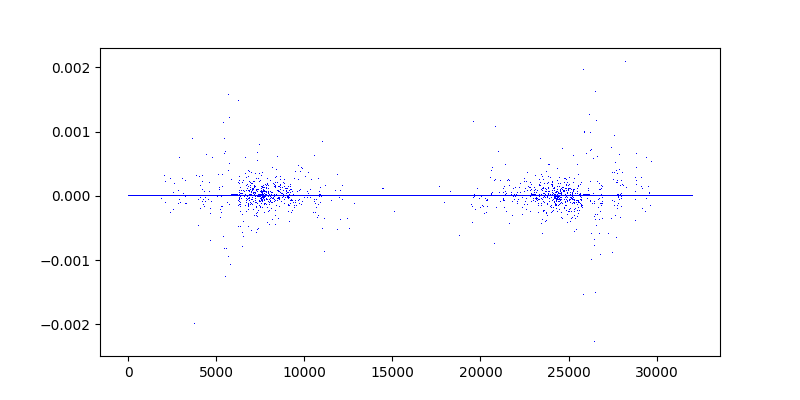

In [120]:
fig = plt.figure(figsize=(8,4))
plt.plot(range(len(fs)), ds-es, 'b,')

In [114]:
eig

(array([6.86279737e-08+0.j]), array([[0.00559017+0.j],
        [0.00559017+0.j],
        [0.00559017+0.j],
        ...,
        [0.00559017+0.j],
        [0.00559017+0.j],
        [0.00559017+0.j]]))

In [12]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=1, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

0.001904940403098113


In [13]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=4, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

0.0005002980927061657


In [3]:
C = SWM(nodes, normals, rbf_obj, eps, k, poly_deg=-1, poly_type='s')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.821766
0.00030839577294799705


# Tangent Plane Method

In [7]:
C = TPM(nodes, normals, rbf_obj, eps, k, poly_deg=2)
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

0.00048721016990151497


In [4]:
C = TPM(nodes, normals, rbf_obj, eps, k, poly_deg=-1)
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon = 0.823559
7.10414912415893e-05


# Symmetric OGr

In [3]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=None, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.439866
0.00010560047226705281


In [4]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=0, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.439866
0.00010517675599315773


In [5]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=1, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.439866
0.00010400431625191328


In [6]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=2, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.439866
9.147184192494719e-05


In [12]:
C = SOGr(nodes, normals, rbf_obj, eps, k, poly_deg=5, poly_type='p')
fs = np.array([forcing(node) for node in nodes])
ds = C @ fs
es = np.array([exact(node) for node in nodes])
print(la.norm(ds - es)/la.norm(es))

epsilon set: 0.439866
3.679303853167017e-11
